# Выбор локации для скважины

### Описание проекта

**Описание проекта**\
Заказчик -  добывающая компания «ГлавРосГосНефть», которой необходимо принять решение, где выгоднее бурить новую скважину.

Заказчик предоставил пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Требуется построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также необходим анализ возможной прибыли и рисков техникой *Bootstrap.*

Шаги выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.


**Описание данных**\
Данные геологоразведки трёх регионов находятся в файлах:\
`geo_data_0.csv`\
`geo_data_1.csv`\
`geo_data_2.csv`

`id` — уникальный идентификатор скважины;\
`f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);\
`product` — объём запасов в скважине (тыс. баррелей).


**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При текущих ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбрать регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


## Загрузка и подготовка данных

### Загрузка библиотек, классов и метрик

In [1]:
!pip install --upgrade scikit-learn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# загружаем функцию для работы с метриками
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression

### Загрузка датасетов и знакомство с данными

In [2]:
# Загрузка датасетов (первый путь для работы в юпитере, второй для гугл колаб)

import os

pth1 = '/datasets/geo_data_0.csv'
pth2 = '/content/geo_data_0.csv'

if os.path.exists(pth1):
    geo_data_0 = pd.read_csv(pth1, sep=',')
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')
elif os.path.exists(pth2):
    geo_data_0 = pd.read_csv(pth2, sep=',')
    geo_data_1 = pd.read_csv('/content/geo_data_1.csv', sep=',')
    geo_data_2 = pd.read_csv('/content/geo_data_2.csv', sep=',')
else:
    print('Something is wrong')

In [3]:
# Посмотрим на датасеты
datasets = {'geo_data_0' : geo_data_0, 'geo_data_1': geo_data_1, 'geo_data_2' : geo_data_2}

for name, dataset in datasets.items():
    print(name)
    print('_____________________________________')
    display(dataset.head(5))
    display(dataset.info())
    print()

geo_data_0
_____________________________________


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


geo_data_1
_____________________________________


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


geo_data_2
_____________________________________


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [4]:
# явные дубли
for name, dataset in datasets.items():
    print(name, ':',dataset.duplicated().sum(), '\n')

geo_data_0 : 0 

geo_data_1 : 0 

geo_data_2 : 0 



Промежуточный вывод:
- данные по трем регионам представлены в трех датасетах, один датасет - один регион
- в каждом датасете из трехв по 10000 строк
- id не числовые, а буквенные (не знаю, важно ли это, наверное, нет)
- пропусков нет
- явных дубликатов нет

Неявные дубликаты, отбросив id, искать нет смысла, поскольку задача о скважинах, смысл закодированных признаков нам неизвестен, и вполне допустимо наличие нескольких скважин с одинаковыми значениями признака и одинаковым продуктом.

### Исследовательский анализ данных

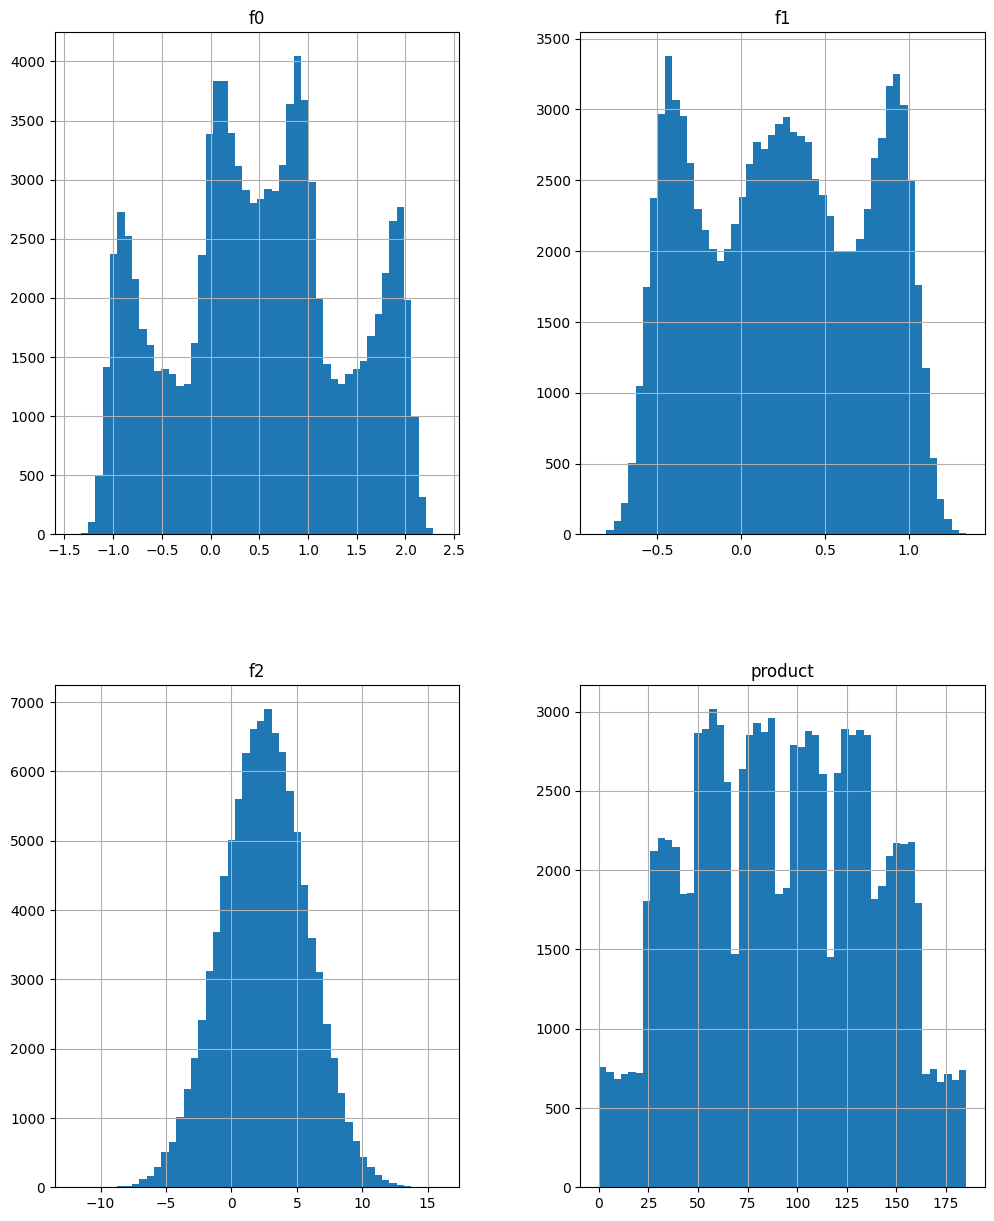

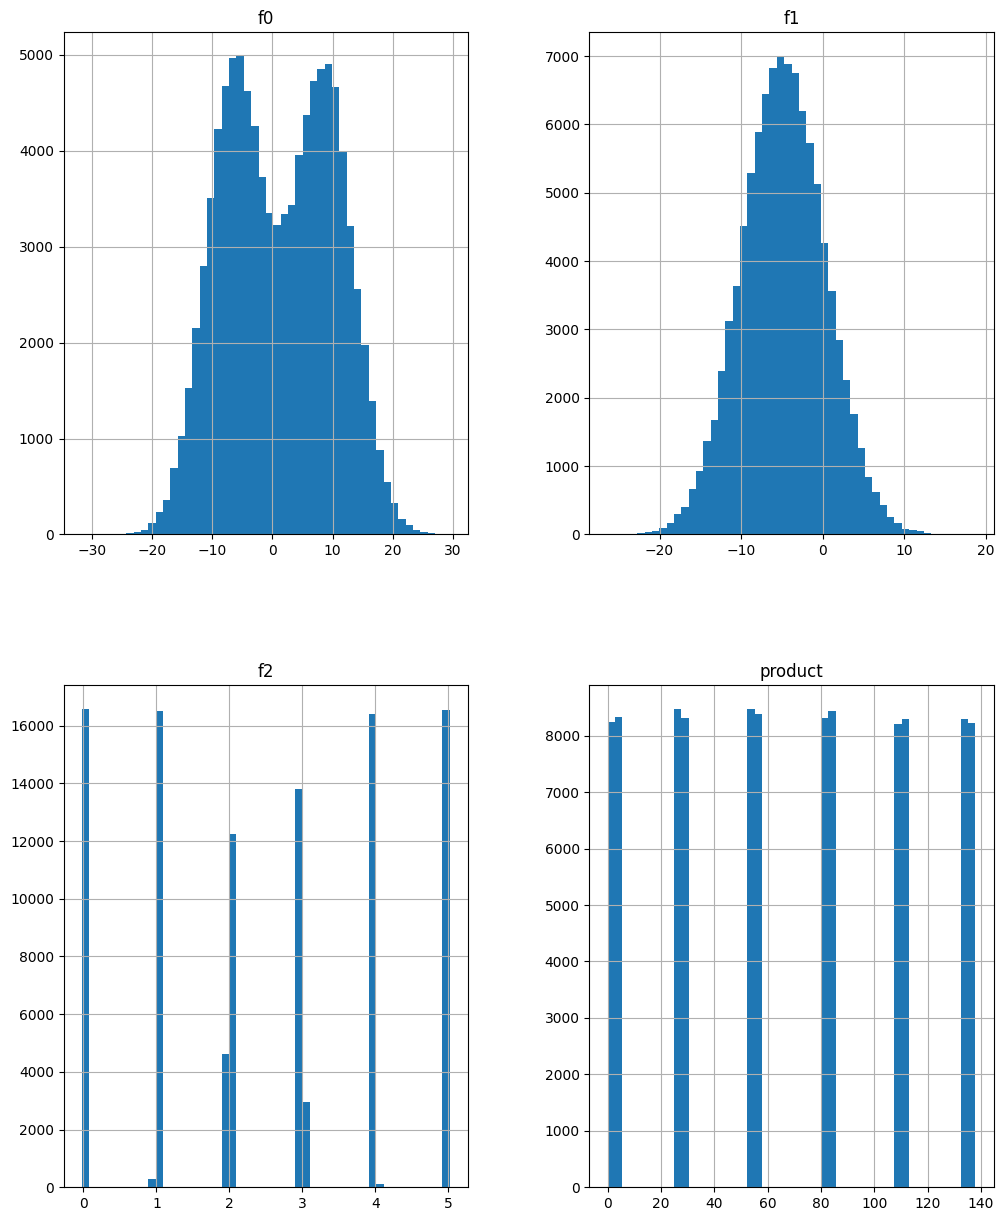

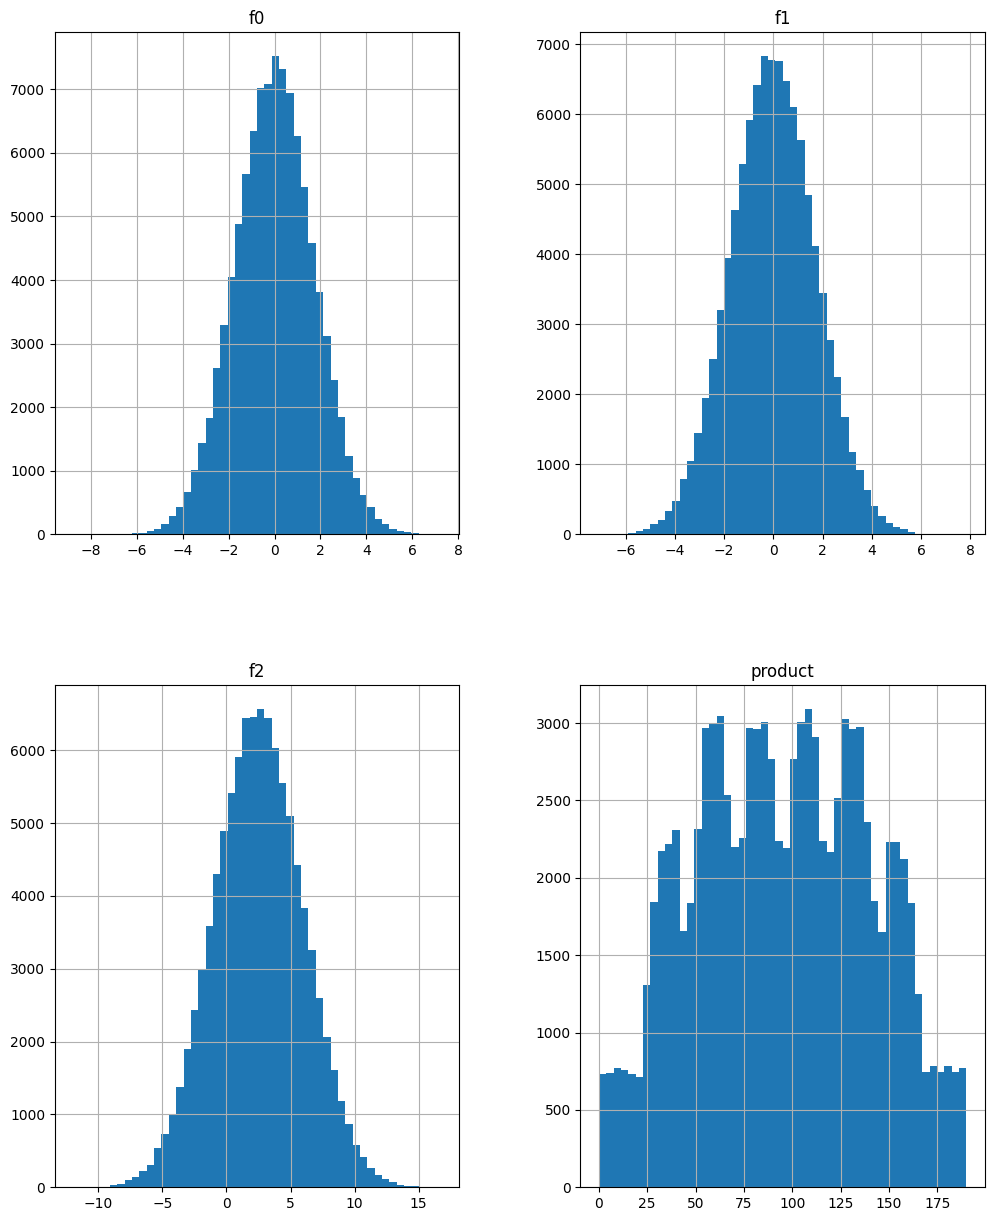

In [5]:
for name, dataset in datasets.items():
    dataset.hist(figsize=(12, 15), bins = 50)
    None

Уже по гистограммам странно выглядит регион_1: у него распределение признака f2 и распределение продукта и близко не похожи на нормальное. Отдельные дискретные значения. Это не выглядит как реальные данные.
Регион_0 и регион_2 без особенностей
Посмотрим на парных диаграммах рассеяния по трем регионам последовательно:

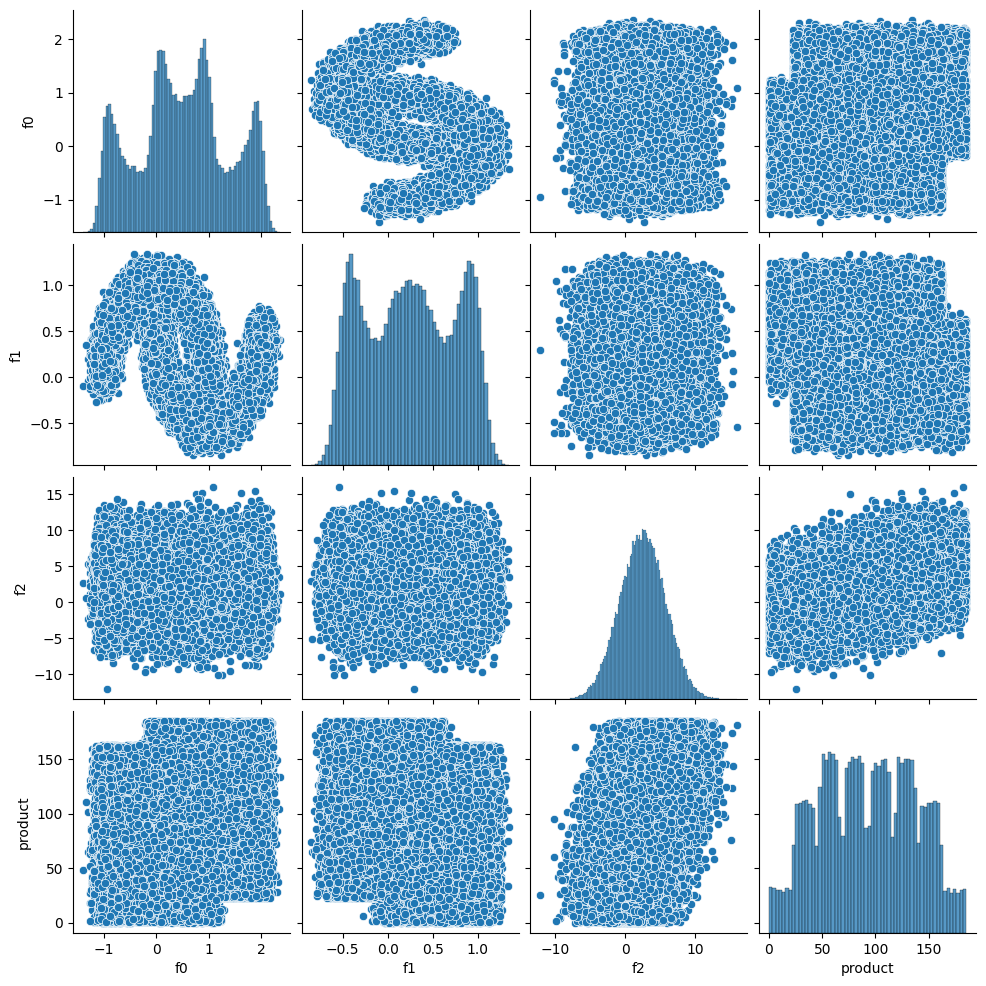

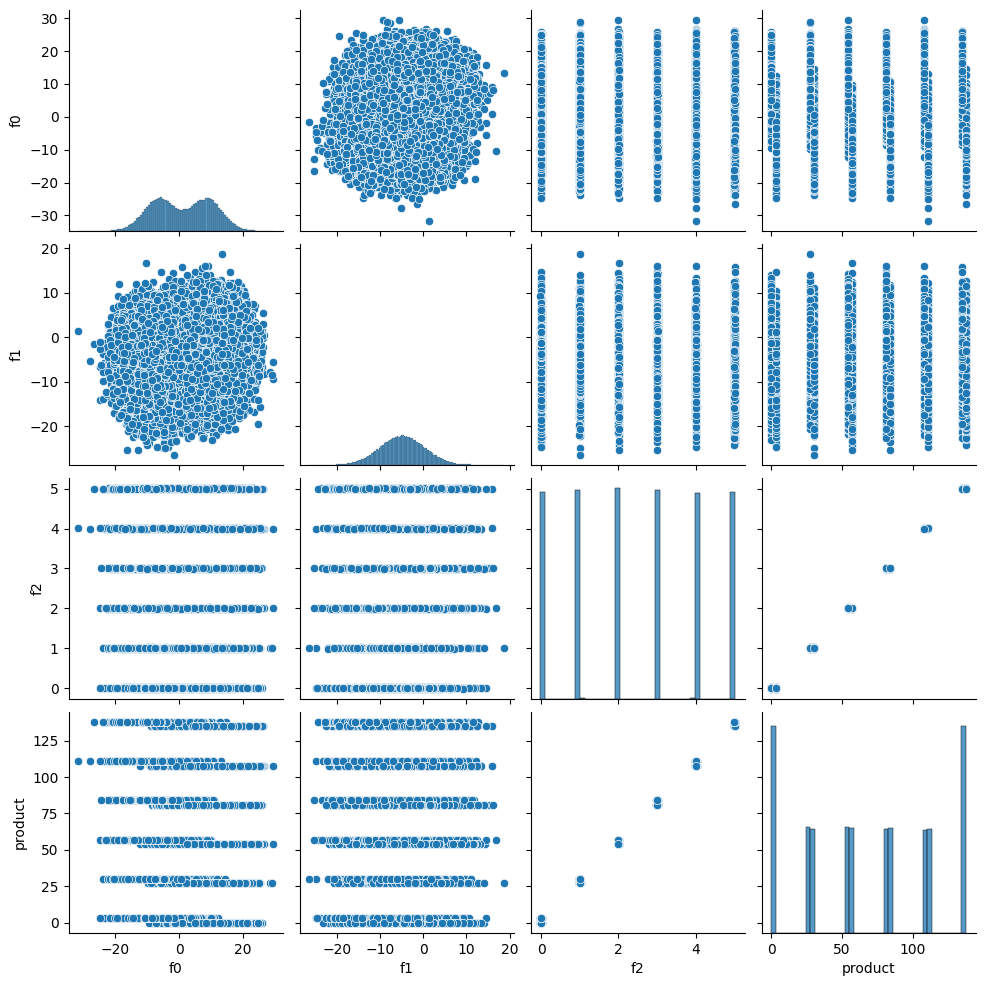

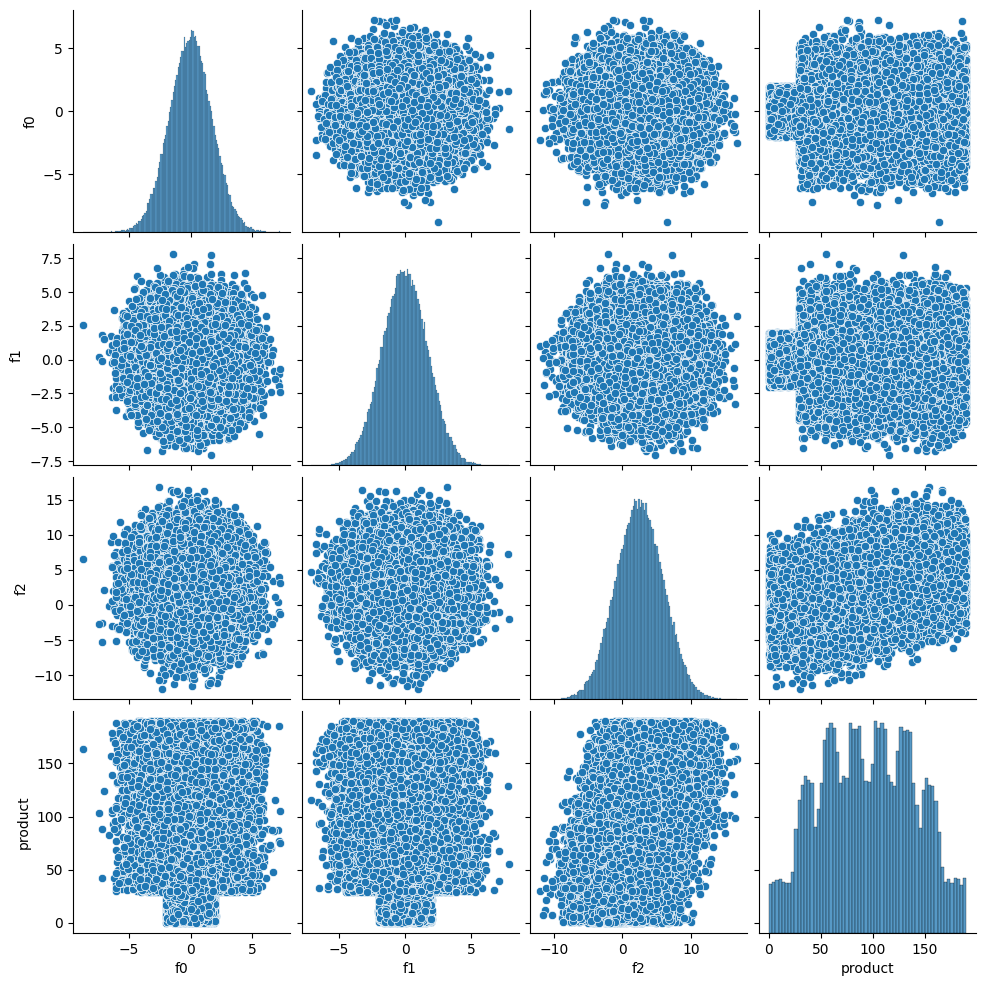

In [6]:
for name, dataset in datasets.items():
    sns.pairplot(dataset)


- По парным диаграммам рассеяния регион_1 тоже выделяется: зависимость признаков f0 и f1 круг, а остальные дискретные. При этом чуть ли не идеальная корреляция проудкта с признаком f2
- Что касается региона_0, здесь видна некоторая корреляция продукта с признаком f2
- Для региона_2 видна определенная корреляция продукта с признаком f2

Построим матрицы корреляции:

<Axes: >

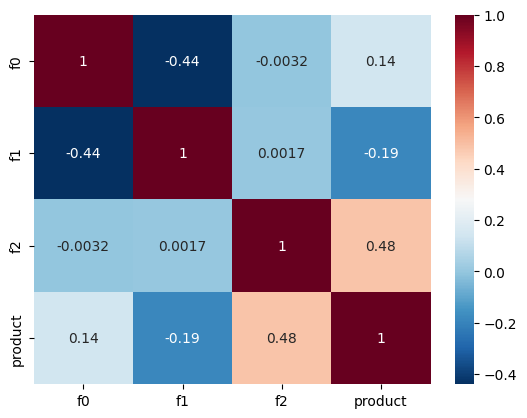

In [7]:
sns.heatmap(
    geo_data_0.drop(['id'], axis = 1).corr(),
    cmap='RdBu_r',
    annot=True,
    )

<Axes: >

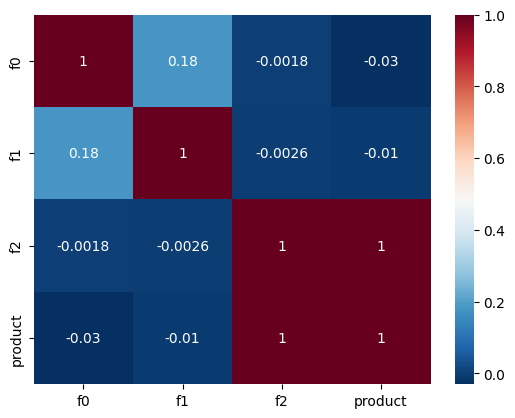

In [8]:
sns.heatmap(
    geo_data_1.drop(['id'], axis = 1).corr(),
    cmap='RdBu_r',
    annot=True,
    )

**Наблюдается утечка признака (корреляция между продуктом и признаком F2 - 1.0). Поскольку нет возможности узнать, что это за признак, и была ли утечка, имеет смысл провести работу как с этим признаком, так и без него**

<Axes: >

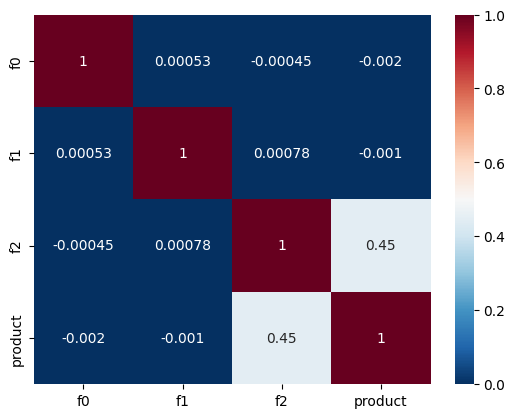

In [9]:
sns.heatmap(
    geo_data_2.drop(['id'], axis = 1).corr(),
    cmap='RdBu_r',
    annot=True,
    )

  Итак, самый важный вывод мы сделали: действительно во всех трех регионах существует заметная корреляция между признаком f2 и продуктом, при этом в регионе_1 корреляция равна 1, похоже, это утечка признака, однако, удалять данный признак опасно, поскольку нет возможности выяснить, что это за признак.

Посмотрим выбросы на всякий случай:

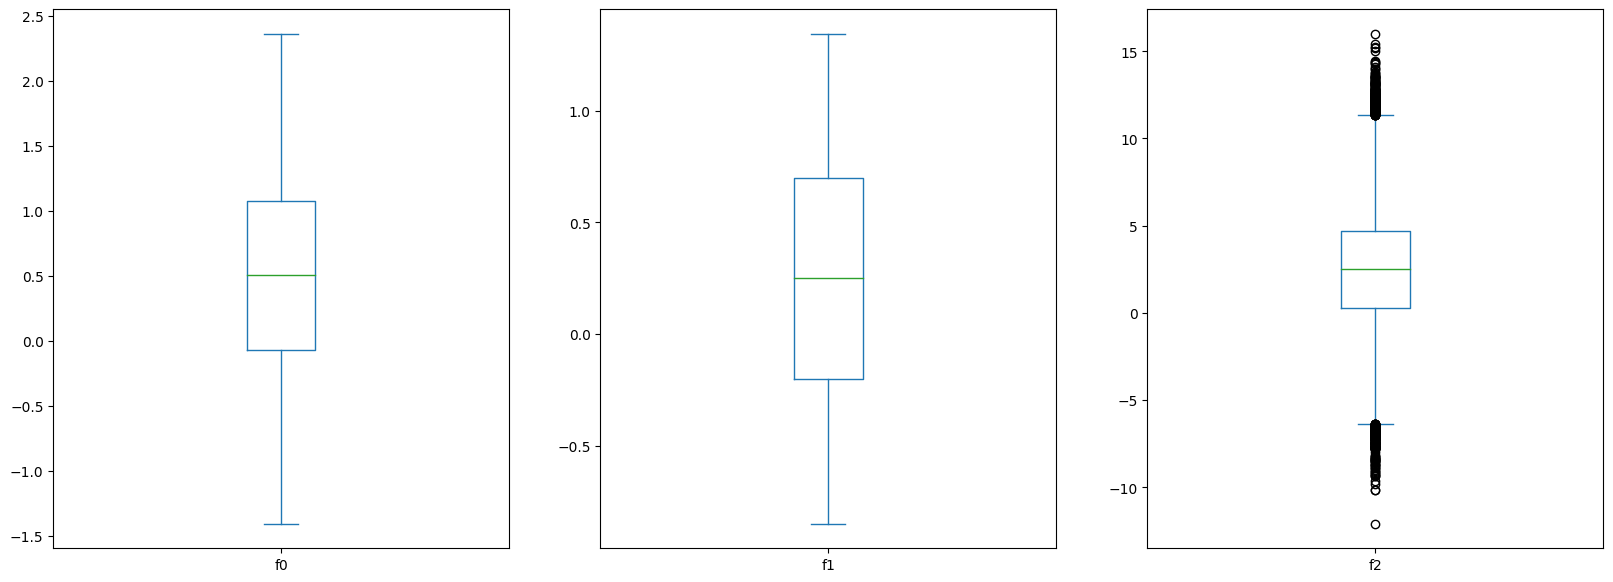

In [10]:
col_list=['f0', 'f1', 'f2']
fig, axarr = plt.subplots(1, 3, figsize=(20, 7))
i=0
for column in col_list:
    geo_data_0[column].plot.box(
        ax=axarr[i],
        )
    i+=1

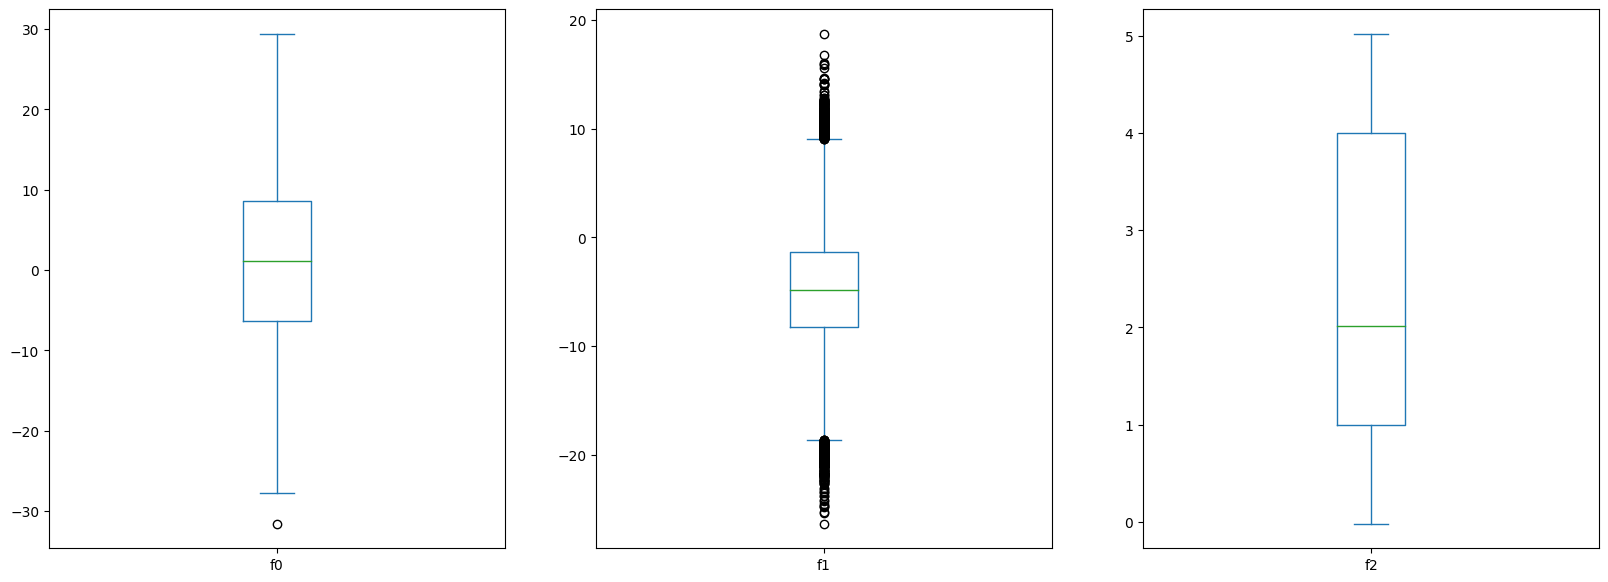

In [11]:
col_list=['f0', 'f1', 'f2']
fig, axarr = plt.subplots(1, 3, figsize=(20, 7))
i=0
for column in col_list:
    geo_data_1[column].plot.box(
        ax=axarr[i],
        )
    i+=1

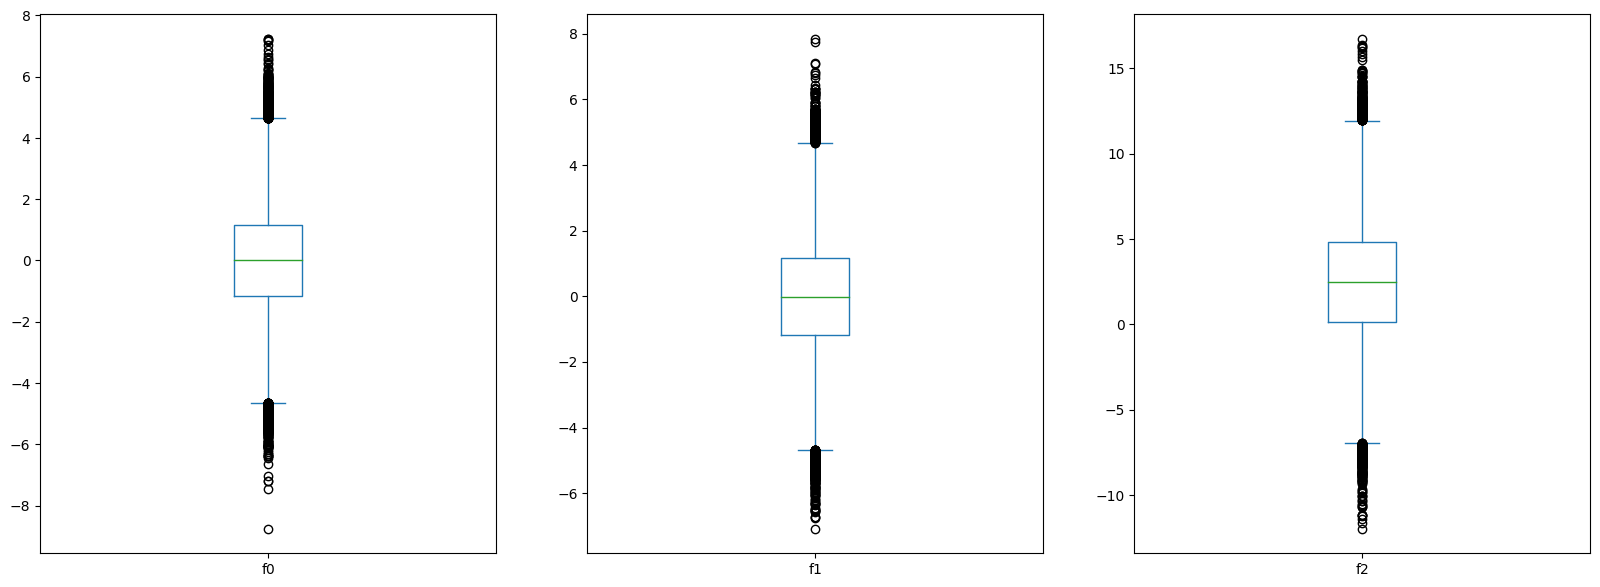

In [12]:
col_list=['f0', 'f1', 'f2']
fig, axarr = plt.subplots(1, 3, figsize=(20, 7))
i=0
for column in col_list:
    geo_data_2[column].plot.box(
        ax=axarr[i],
        )
    i+=1

Выбросов нет, есть редко встречающиеся значения, их оставляем.

<ipython-input-13-21b09e7d34ee>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['product'], label=i)
<ipython-input-13-21b09e7d34ee>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['product'], label=i)
<ipython-input-13-21b09e7d34ee>:3: UserWarning: 

`distplot` is a deprecated function 

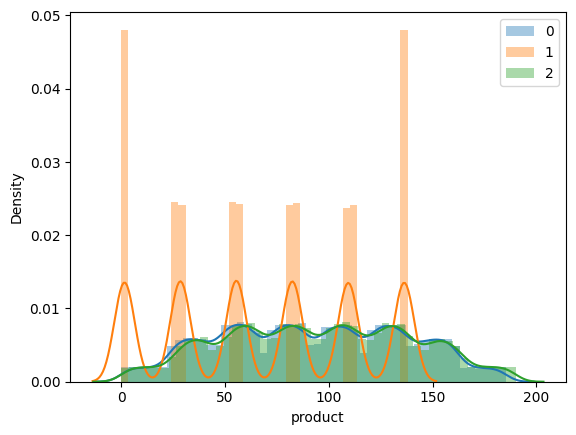

In [13]:
dfs = [geo_data_0, geo_data_1, geo_data_2]
for i, df in enumerate(dfs):
    sns.distplot(df['product'], label=i)
    plt.legend()
    None

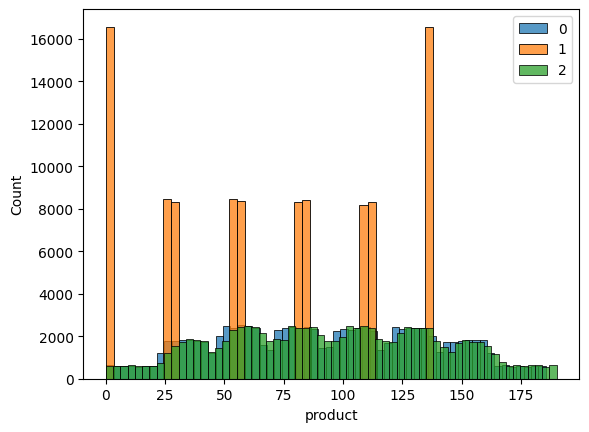

In [14]:
dfs = [geo_data_0, geo_data_1, geo_data_2]
for i, df in enumerate(dfs):
    sns.histplot(df['product'], label=i)
    plt.legend()
    None

Когда мы наложили на одном графике распределение запасов по месторождениям всех трех регионов, стало еще более наглядно видно отличие в запасах первого региона, от запасов нулевого и второго регионов.
В принципе, это и по гистограммам было видно: по региону 1 такое ощущение, что данные подделаны, такого распределения просто не может существовать в реальности.

Подготовим первый вариант данных региона_1 для модели (с удалением признака f2):

In [15]:
geo_data_1_dropf2 = geo_data_1.drop(['f2'], axis = 1)
geo_data_1_dropf2.head(3)

,id,f0,f1,product
0,kBEdx,-15.001348,-8.276000,3.179103
1,62mP7,14.272088,-3.475083,26.953261
2,vyE1P,6.263187,-5.948386,134.766305


## Обучение и проверка модели

### Подготовка данных

In [16]:
# создадим константу RANDOM_STATE
RANDOM_STATE = 42

# Создадим функцию подготовки данных:
def data_preprocessing(geo_data):

    # Разделение датафреймов на целевую и нецелевую выборку
    X = geo_data.drop(['id', 'product'], axis=1)
    y = geo_data['product']

    # Разделение целевой и нецелевой выборки
    # на обучающие и тестовые выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=.25,
        random_state=RANDOM_STATE
    )

    return X_train, X_test, y_train, y_test

In [17]:
# определяем метод масштабирования
scaler = StandardScaler()

# обучаем скейлер на количественных признаках тренировочной выборки и масштабируем тренировочную выборку
# масштабируем тестовую выборку
def data_scaler(X_train, X_test):
    X_train_scaled =  scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])

    # создадим датафрейм из масштабированных данных
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

    return X_train_scaled, X_test_scaled

In [18]:
def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred))**(1/2)

### Регион 0

In [19]:
X0_train,  X0_test, y0_train, y0_test = data_preprocessing(geo_data_0)

X0_test.head()

,f0,f1,f2
75721,0.599283,-0.557623,2.121187
80184,0.739017,-0.463156,-1.347584
19864,1.422743,-0.534917,3.718798
76699,1.580244,-0.238458,2.805149
92991,0.918974,0.023961,2.598575


In [20]:
num_col_names = ['f0', 'f1', 'f2']
X0_train, X0_test = data_scaler(X0_train, X0_test)
X0_test.head()

,f0,f1,f2
0,0.113830,-1.605391,-0.119836
1,0.274030,-1.417818,-1.187407
2,1.057896,-1.560307,0.371855
3,1.238466,-0.971658,0.090665
4,0.480343,-0.450600,0.027088


In [21]:
# инициализируем и обучим модель
model_lr  = LinearRegression()
model_lr.fit(X0_train, y0_train)

# получим предсказанные значения для X_test
predictions0 = model_lr.predict(X0_test)

# выведем первое предсказанное и настоящее значения
print(predictions0[0], y0_test.reset_index(drop=True)[0])

101.90101715471782 122.073349831204


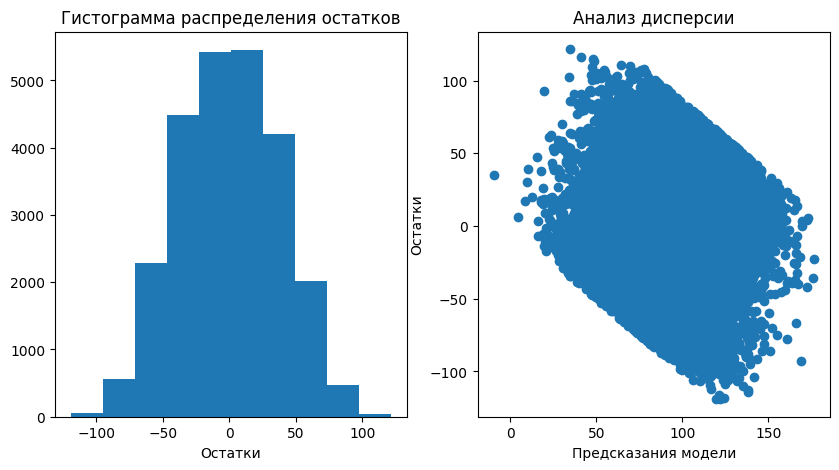

In [22]:
# проведем анализ остатков
# рассчитаем остатки
residuals0 = y0_test - predictions0

# построим графики по количественным признакам — гистограмму частотности
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals0)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions0, residuals0)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()


По остаткам все хорошо: гистограмма распределения близка к нормальной, дисперсия также выглядит неплохо.

In [23]:
rmse0=rmse(y0_test.reset_index(drop=True), predictions0)
print(rmse0, predictions0.mean())

37.75660035026169 92.39879990657768


In [24]:
# Начнем собирать сравнительную табличку по трем регионам
results={'Среднее предсказанное значение': [],
           'Среднеквадратичная ошибка': []
           }

results['Среднее предсказанное значение'].append(predictions0.mean())
results['Среднеквадратичная ошибка'].append(rmse0)

### Регион 1

In [25]:
# Разбиваем:
X1_train,  X1_test, y1_train, y1_test = data_preprocessing(geo_data_1_dropf2)
# Масштабируем:
num_col_names = ['f0', 'f1']
X1_train, X1_test = data_scaler(X1_train, X1_test)

# инициализируем и обучим модель
model_lr  = LinearRegression()
model_lr.fit(X1_train, y1_train)

# получим предсказанные значения для X_test
predictions1 = model_lr.predict(X1_test)

# выведем первое предсказанное и настоящее значения
print(predictions1[0], y1_test.reset_index(drop=True)[0])

67.92636741909898 0.0


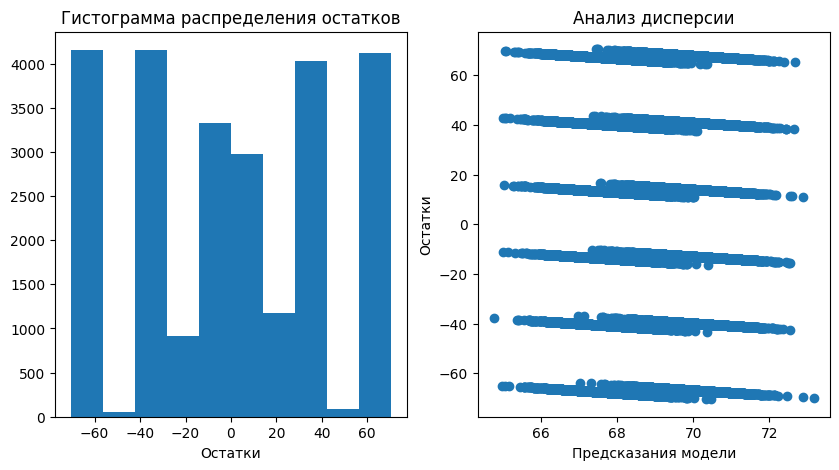

In [26]:
# проведем анализ остатков
# рассчитаем остатки
residuals1 = y1_test - predictions1

# построим графики по количественным признакам — гистограмму частотности
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals1)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions1, residuals1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()


Анализ остатков говорит, что данных недостаточно (гистограмма распределения не похожа на нормальное распределение), а анализ дисперсии вообще имеет странный вид. Тут явно что-то с исходными данными не то, по этому региону, до выяснения обстоятельств лучше с этим регионом не связываться.

In [27]:
rmse1=rmse(y1_test.reset_index(drop=True), predictions1)
print(rmse1, predictions1.mean())

45.92399973816207 68.8488613646765


In [28]:
results['Среднее предсказанное значение'].append(predictions1.mean())
results['Среднеквадратичная ошибка'].append(rmse1)

### Регион 2

In [29]:
# Разбиваем:
X2_train,  X2_test, y2_train, y2_test = data_preprocessing(geo_data_2)
# Масштабируем:
num_col_names = ['f0', 'f1', 'f2']
X2_train, X2_test = data_scaler(X2_train, X2_test)

# инициализируем и обучим модель
model_lr  = LinearRegression()
model_lr.fit(X2_train, y2_train)

# получим предсказанные значения для X_test
predictions2 = model_lr.predict(X2_test)

# выведем первое предсказанное и настоящее значения
print(predictions2[0], y2_test.reset_index(drop=True)[0])

98.30191642040977 117.44130066629592


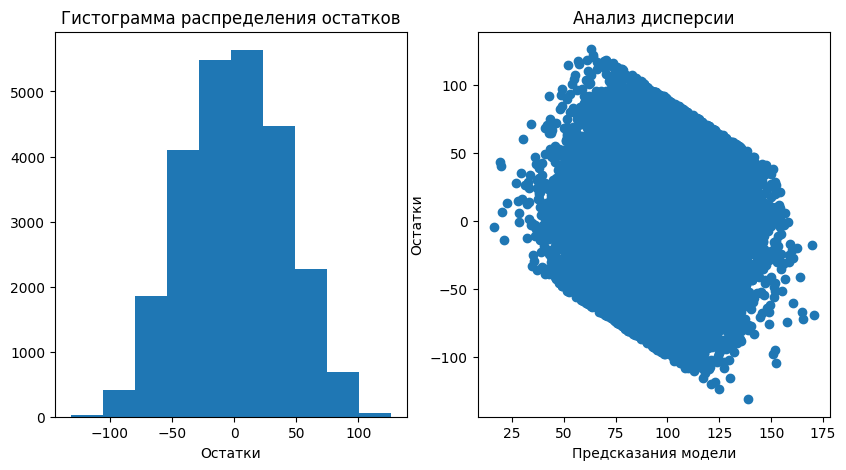

In [30]:
# проведем анализ остатков
# рассчитаем остатки
residuals2 = y2_test - predictions2

# построим графики по количественным признакам — гистограмму частотности
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals2)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions2, residuals2)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

По остаткам все хорошо: гистограмма распределения близка к нормальной, дисперся также выглядит неплохо.

In [31]:
rmse2=rmse(y2_test.reset_index(drop=True), predictions2)
print(rmse2, predictions2.mean())

40.145872311342174 94.77102387765939


In [32]:
results['Среднее предсказанное значение'].append(predictions2.mean())
results['Среднеквадратичная ошибка'].append(rmse2)

In [33]:
results = pd.DataFrame(results)
results

,Среднее предсказанное значение,Среднеквадратичная ошибка
0,92.398800,37.756600
1,68.848861,45.924000
2,94.771024,40.145872


### Промежуточный вывод
Наименее перспективным регионом является первый регион (geo_data_1). Здесь самое низкое предсказанное значение продукта и самая высокая среднеквадратичная ошибка. К тому же, анализ остатков показал, что по нему с данными что-то не то.
Из оставшихся (geo_data_0 и geo_data_2) нулевой регион дает чуть меньший средний результат по продукту, но с меньшей ошибкой чем регион 2. В принципе, они похожи, и следует, вероятно, решать по прибыли.


## Подготовка к расчёту прибыли

In [34]:
# Константы проекта
OBJECTS_SUM = 500 # количество точек в исследовании
BEST_OBJECTS_SUM = 200 # количество лучших точек в регионе(из 500 исследованных)
BUDGET = 10000000000 #бюджет на каждый регион
INCOME_PER_UNIT = 450000 # доходность одной единицы product (450 за баррель * 1000 баррелей в одной единице в столбце 'product')
LOSS_MAX = .025 # максимально допустимая веросятность убытков

In [35]:
# Точка безубыточности
break_event_point = (BUDGET / INCOME_PER_UNIT) / BEST_OBJECTS_SUM
print(f'Точка безубыточности равна добыче {break_event_point} баррелей в каждой из 200 скважин одного региона.')

Точка безубыточности равна добыче 111.11111111111111 баррелей в каждой из 200 скважин одного региона.


In [36]:
results['Среднее предсказанное значение'] - break_event_point

,Среднее предсказанное значение
0,-18.712311
1,-42.262250
2,-16.340087


Что касается средних предсказанных моделью знаечний, здесь все плохо, и ни один регион не дотягивает до необходимого минимума в 111 баррелей. Лучше здесь выглядит 2й регион (geo_2)

In [37]:
print('Нулевой регион (лучшие скважины):', pd.Series(predictions0).sort_values(ascending=False).head(200).mean() - break_event_point)
print('Первый регион (лучшие скважины):', pd.Series(predictions1).sort_values(ascending=False).head(200).mean() - break_event_point)
print('Второй регион (лучшие скважины):', pd.Series(predictions2).sort_values(ascending=False).head(200).mean() - break_event_point)

Нулевой регион (лучшие скважины): 43.29620532962386
Первый регион (лучшие скважины): -39.1327286337565
Второй регион (лучшие скважины): 37.53312793016613


### Промежуточный вывод

Для безубыточности проекта минимальный объем добычи в одной скважине должен быть 111 тыс. баррелей.

При этом, средние значения предсказанных объемов добычи в одной скважине всех регионов меньше этого значения минимум на 16 тыс. баррелей.

Однако, средние значения 200 скважин с максимальным предсказанным объемом нефти в 0 и 2м регионах превышают точку безубыточности. Лидирует 0й регион.

## Расчёт прибыли и рисков

### Функция расчета прибыли

In [38]:
# Функция расчета прибыли
def profit_calc(df):
    # df = columns 'id', 'product', 'predict'

    # Выбор 200 скважин в первом регионе
    # с максимальным предсказанным значением
    # запасов нефти
    df_200 = df.sort_values(
        by='predict',
        ascending=False
    ).head(BEST_OBJECTS_SUM)

    # Расчет прибыли целевых значений,
    # соответствующих 200 предсказаниям
    # с максимальными значениями запасов нефти
    return (df_200['product'].sum() * INCOME_PER_UNIT) - BUDGET

### Функция расчета доходов и убытков

In [39]:
# Функция расчета доходов и убытков
def profit_and_loss(target_test, predict):

    # Создание единого датафрейма
    df = pd.DataFrame({
        'product':target_test.values,
        'predict':predict
    })

    # Значение для random_state
    RANDOM_STATE = np.random.RandomState(42)
    # Массив доходности после применения техники bootstrep
    profit_bootstrep = []

    for i in range(0, 1000, 1):
        df_sample = df.sample(
            n=500,
            replace=True,
            random_state=RANDOM_STATE
        )

        profit_bootstrep.append(profit_calc(df_sample))

    profit_bootstrep = pd.Series(profit_bootstrep)
    # Средний доход
    mean_profit = int(profit_bootstrep.mean())
    # Нижний квантиль 2.5% от 95% доверительного интервала
    lower_profit = int(profit_bootstrep.quantile(.025))
    # Верхний квантиль 97.5% от 95% доверительного интервала
    upper_profit = int(profit_bootstrep.quantile(.975))
    # Вероятность убытка
    probability_of_loss = (profit_bootstrep.values < 0).mean()

    print(f'95% доверительный интервал доходности находится в пределах от {lower_profit} до {upper_profit}')
    print('Средний доход     :', mean_profit)
    print(f'Вероятность убытка: {probability_of_loss*100}%')

    return mean_profit, probability_of_loss

In [40]:
# Массив средней доходности и вероянтости убытков
# mppl - mean profit and probability of loss
mean_profits = []
probabilities_of_losses = []

### Расчет ожидаемой прибыли и вероятности убытков

**Регион 0**

In [41]:
# Регион 0
mean_profit, probabilitу_of_loss = profit_and_loss(y0_test, predictions0)
mean_profits.append(mean_profit)
probabilities_of_losses.append(probabilitу_of_loss)

95% доверительный интервал доходности находится в пределах от -110467895 до 897460327
Средний доход     : 399575478
Вероятность убытка: 6.0%


**Регион 1**

In [42]:
# Регион 1
mean_profit, probabilitу_of_loss = profit_and_loss(y1_test, predictions1)
mean_profits.append(mean_profit)
probabilities_of_losses.append(probabilitу_of_loss)

95% доверительный интервал доходности находится в пределах от -4245946305 до -3154846162
Средний доход     : -3700856201
Вероятность убытка: 100.0%


**Регион 2**

In [43]:
# Регион 2
mean_profit, probabilitу_of_loss = profit_and_loss(y2_test, predictions2)
mean_profits.append(mean_profit)
probabilities_of_losses.append(probabilitу_of_loss)

95% доверительный интервал доходности находится в пределах от -144766727 до 888390403
Средний доход     : 375009902
Вероятность убытка: 8.0%


### Выводы расчета прибыли и рисков

In [44]:
# Выводы расчета прибыли и рисков
mppl_df = pd.DataFrame(
    {
        'profit':mean_profits,
        'probability_of_loss':probabilities_of_losses
    }
)
mppl_df = mppl_df.loc[mppl_df['probability_of_loss'] < LOSS_MAX]
mppl_df = mppl_df.loc[mppl_df['profit'] == mppl_df['profit'].max()]

mppl_df

,profit,probability_of_loss


Среди указанных регионов нет региона, подходящего по требованиям для инвестирования.
Возможно, если не удалять в первом регионе признак f2, картина будет иная (и мы проверим это ниже), но рекомендовать его к инвестированию небезопасно, поскольку данные выглядят некорректно, и, по всей видимости, там произошла ручная подделка данных.

### Расчет 1 региона без удаления f2.

In [45]:
geo_data_1.head(5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [46]:
# Разбиваем:
X1_train,  X1_test, y1_train, y1_test = data_preprocessing(geo_data_1)
# Масштабируем:
num_col_names = ['f0', 'f1', 'f2']
X1_train, X1_test = data_scaler(X1_train, X1_test)

# инициализируем и обучим модель
model_lr  = LinearRegression()
model_lr.fit(X1_train, y1_train)

# получим предсказанные значения для X_test
predictions1 = model_lr.predict(X1_test)

# выведем первое предсказанное и настоящее значения
print(predictions1[0], y1_test.reset_index(drop=True)[0])

0.8447380626897285 0.0


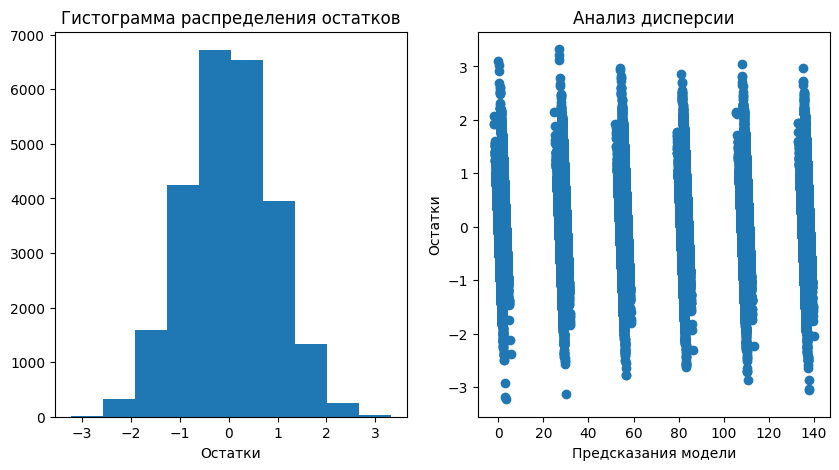

In [47]:
# проведем анализ остатков
# рассчитаем остатки
residuals1 = y1_test - predictions1

# построим графики по количественным признакам — гистограмму частотности
# распределения и диаграмму рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals1)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions1, residuals1)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()


In [48]:
rmse1=rmse(y1_test.reset_index(drop=True), predictions1)
print(rmse1, predictions1.mean())

0.8902801001028845 68.7128780391376


In [49]:
# Регион 1, модель с f2
mean_profit, probabilitу_of_loss = profit_and_loss(y1_test, predictions1)
mean_profits.append(mean_profit)
probabilities_of_losses.append(probabilitу_of_loss)

95% доверительный интервал доходности находится в пределах от 61684479 до 845340177
Средний доход     : 452048890
Вероятность убытка: 1.5%


In [50]:
# Выводы расчета прибыли и рисков
mppl_df = pd.DataFrame(
    {
        'profit':mean_profits,
        'probability_of_loss':probabilities_of_losses
    }
)
mppl_df = mppl_df.loc[mppl_df['probability_of_loss'] < LOSS_MAX]
mppl_df = mppl_df.loc[mppl_df['profit'] == mppl_df['profit'].max()]

mppl_df

,profit,probability_of_loss
3,452048890,0.015


Едиcтвенный регион из всех, в котором риск убытков умещается в требуемый интервал - это регион 1 (geo_data_1).
Вероятность убытка здесь всего 1,5%, что менее 2,5%, требуемых по условиям исследования. Средний расчетный доход 452048890 и 95% доверительный интервал доходности находится в пределах от 61684479 до 845340177

### Итоговый вывод и рекомендации

По итогам исследования рекомендуется к инвестированию регион 1 (geo_data_1):
- 95% доверительный интервал доходности находится в пределах от 61684479 до 845340177
- Средний доход     : 452048890
- Вероятность убытка: 1.5%

Однако, исходя из визуализации данных, также рекомендую перед принятием решения об инвестировании тщательно проверить данные по данному региону 1 (geo_data_1), возможно, там произошла подделка данных.

Остальные регионы (geo_data_0 и geo_data_2) не дотягивают по риску убытков (6 и 8% риска) соответственно.